# PWPAE: An Ensemble Framework for Concept Drift Adaptation in IoT Data Streams
This is the code for the paper entitled "**PWPAE: An Ensemble Framework for Concept Drift Adaptation in IoT Data Streams**" accepted in 2021 IEEE Global Communications Conference (GLOBECOM).  
Authors: Li Yang (lyang339@uwo.ca), Dimitrios Michael Manias (dmanias3@uwo.ca), and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

L. Yang, D. M. Manias, and A. Shami, “PWPAE: An Ensemble Framework for Concept Drift Adaptation in IoT Data Streams,” in 2021 IEEE Glob. Commun. Conf. (GLOBECOM), Madrid, Spain, Dec. 2021.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import time

## Read the sampled IoTIDS20 dataset

In [2]:
df = pd.read_csv("./data/IoT_2020_b_0.01_fs.csv")
# df = df.sample(n=None, frac=0.1, replace=False, weights=None, random_state=None, axis=0)
# df = df.sort_index()

## Train-test split
10% training set, and 90% test set

In [3]:
X = df.drop(['Label'],axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.1, test_size = 0.9, shuffle=False,random_state = 0)

## Online Learning

Four base online learners for ensemble: 
* Adaptive Random Forest (ARF) model with ADWIN drift detector (ARF-ADWIN)
* Adaptive Random Forest (ARF) model with DDM drift detector (ARF-DDM)
* Streaming Random Patches (SRP) model with ADWIN drift detector (SRP-ADWIN)
* Streaming Random Patches (SRP) model with DDM drift detector (SRP-DDM)

Three other online learners for comparison:
* Extremely Fast Decision Tree (EFDT)
* Hoeffding Tree (HT)
* Leveraging Bagging (LB)

An ensemble online learner proposed in the paper:
* Performance Weighted Probability Averaging Ensemble (PWPAE)
   * It combines the 4 base online learners by weighting them based on their accuracy and classification probabilities

In [4]:
# Import the online learning metrics and algorithms from the River library
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model
from river.drift import DDM, ADWIN

In [5]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set

    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1,yi1) 

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred= model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi,yi) # Learn the test sample
        metric = metric.update(yi, y_pred) # Update the real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

### Base model learning

In [6]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on IoTID20 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

Accuracy: 98.15%
Precision: 98.44000000000001%
Recall: 99.62%
F1-score: 99.03%
Wall time: 5.28 s


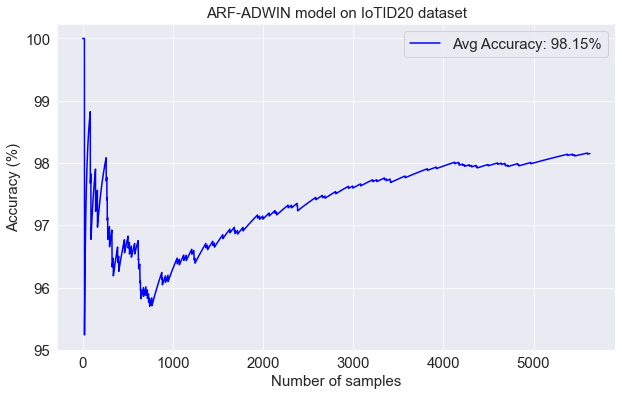

In [7]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector
name1 = "ARF-ADWIN model"
model1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 98.42%
Precision: 98.69%
Recall: 99.64%
F1-score: 99.17%
Wall time: 5.07 s


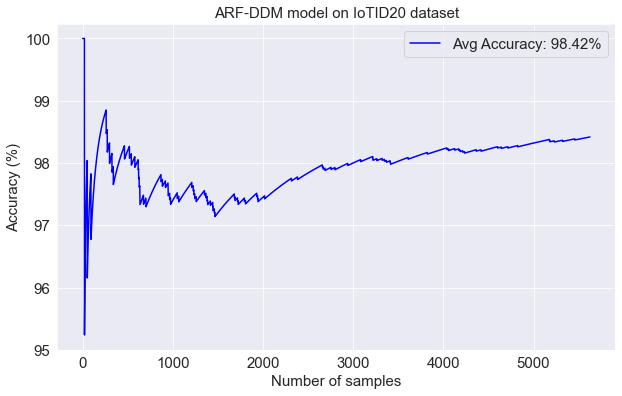

In [8]:
%%time
# Use the Adaptive Random Forest (ARF) model with DDM drift detector
name2 = "ARF-DDM model"
model2 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = DDM()) # Define the model
t, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m2, name2) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 98.05%
Precision: 98.4%
Recall: 99.55000000000001%
F1-score: 98.97%
Wall time: 20.4 s


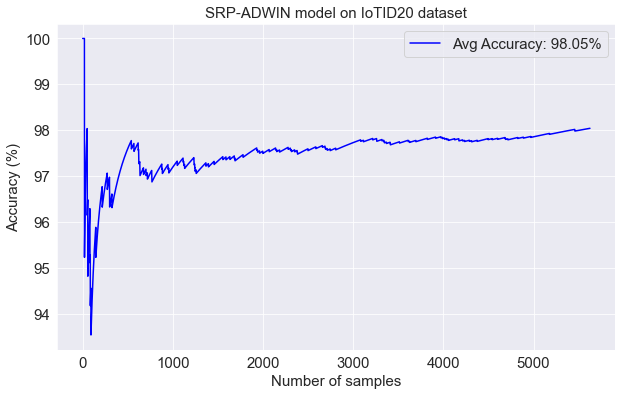

In [9]:
%%time
# Use the Streaming Random Patches (SRP) model with ADWIN drift detector
name3 = "SRP-ADWIN model"
model3 = ensemble.SRPClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
t, m3 = adaptive_learning(model3, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m3, name3) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 98.9%
Precision: 99.14%
Recall: 99.7%
F1-score: 99.42%
Wall time: 19.5 s


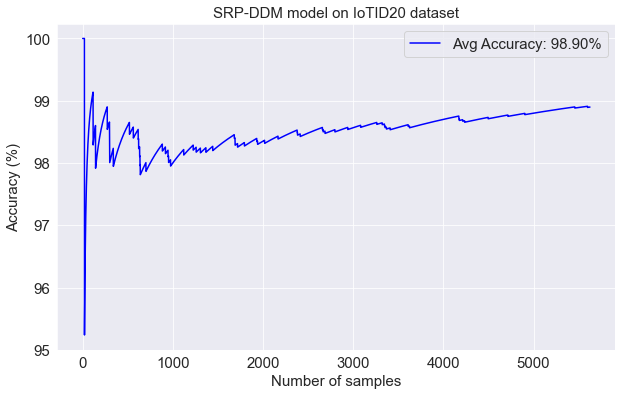

In [10]:
%%time
# Use the Streaming Random Patches (SRP) model with DDM drift detector
name4 = "SRP-DDM model"
model4 = ensemble.SRPClassifier(n_models = 3, drift_detector = DDM()) # Define the model
t, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m4, name4) # Draw the figure of how the real-time accuracy changes with the number of samples

### Comparison model learning

Accuracy: 97.19%
Precision: 97.53%
Recall: 99.55000000000001%
F1-score: 98.53%
Wall time: 1.85 s


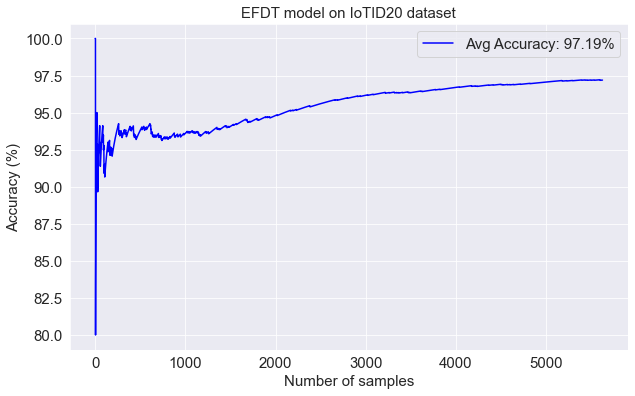

In [11]:
%%time
# Use the Extremely Fast Decision Tree (EFDT) model 
name5 = "EFDT model"
model5 = tree.ExtremelyFastDecisionTreeClassifier() # Define the model
t, m5 = adaptive_learning(model5, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m5, name5) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 95.45%
Precision: 95.91%
Recall: 99.42%
F1-score: 97.63%
Wall time: 1.9 s


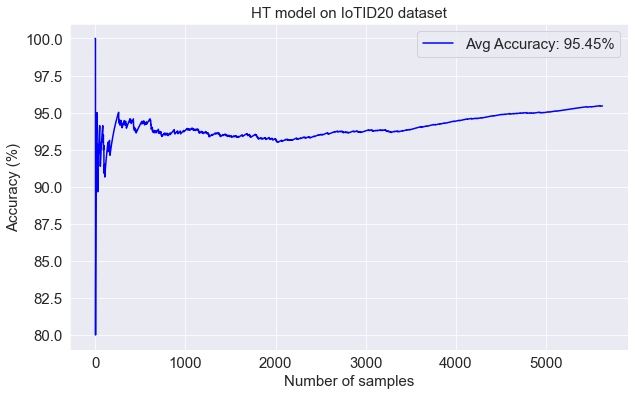

In [12]:
%%time
# Use the Hoeffding Tree (HT) model 
name6 = "HT model"
model6 = tree.HoeffdingTreeClassifier() # Define the model
t, m6 = adaptive_learning(model6, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m6, name6) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 97.65%
Precision: 98.03%
Recall: 99.51%
F1-score: 98.77%
Wall time: 25.4 s


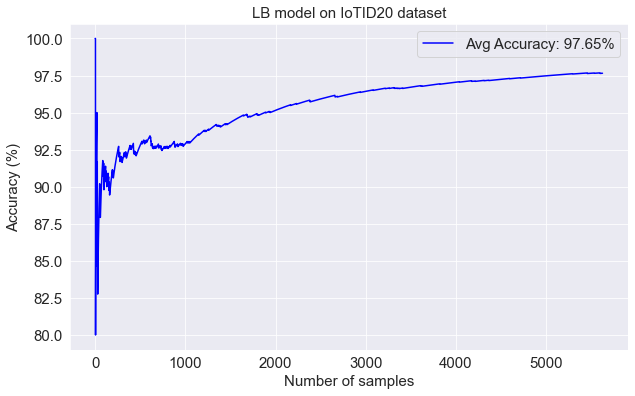

In [13]:
%%time
# Use the Leveraging Bagging (LB) model 
name7 = "LB model"
model7 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3) # Define the model
t, m7 = adaptive_learning(model7, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m7, name7) # Draw the figure of how the real-time accuracy changes with the number of samples

### PWPAE ensemble model learning

In [14]:
# Define the Performance Weighted Probability Averaging Ensemble (PWPAE) model
def PWPAE(X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
    hat2 = ensemble.SRPClassifier(n_models=3) # SRP-ADWIN
    hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # ARF-DDM
    hat4 = ensemble.SRPClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # SRP-DDM

    # The four base learners learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The four base learner predict the labels
        y_pred1= hat1.predict_one(xi) 
        y_prob1= hat1.predict_proba_one(xi) 
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi) 
        y_prob2= hat2.predict_proba_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi) 
        y_prob3= hat3.predict_proba_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi) 
        y_prob4= hat4.predict_proba_one(xi)
        hat4.learn_one(xi,yi)
        
        # Record their real-time accuracy
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)    

        # Calculate the real-time error rates of four base learners
        e1 = 1-metric1.get()
        e2 = 1-metric2.get()
        e3 = 1-metric3.get()
        e4 = 1-metric4.get()

        
        ep = 0.001 # The epsilon used to avoid dividing by 0
        # Calculate the weight of each base learner by the reciprocal of its real-time error rate
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea

        # Make ensemble predictions by the classification probabilities
        if  y_pred1 == 1:
            ypro10=1-y_prob1[1]
            ypro11=y_prob1[1]
        else:
            ypro10=y_prob1[0]
            ypro11=1-y_prob1[0]
        if  y_pred2 == 1:
            ypro20=1-y_prob2[1]
            ypro21=y_prob2[1]
        else:
            ypro20=y_prob2[0]
            ypro21=1-y_prob2[0]
        if  y_pred3 == 1:
            ypro30=1-y_prob3[1]
            ypro31=y_prob3[1]
        else:
            ypro30=y_prob3[0]
            ypro31=1-y_prob3[0]
        if  y_pred4 == 1:
            ypro40=1-y_prob4[1]
            ypro41=y_prob4[1]
        else:
            ypro40=y_prob4[0]
            ypro41=1-y_prob4[0]        

        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w1*ypro10+w2*ypro20+w3*ypro30+w4*ypro40
        y_prob_1 = w1*ypro11+w2*ypro21+w3*ypro31+w4*ypro41

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1
        
        # Update the real-time accuracy of the ensemble model
        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        
        i=i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

Accuracy: 99.13%
Precision: 99.08%
Recall: 100.0%
F1-score: 99.53999999999999%
Wall time: 51.3 s


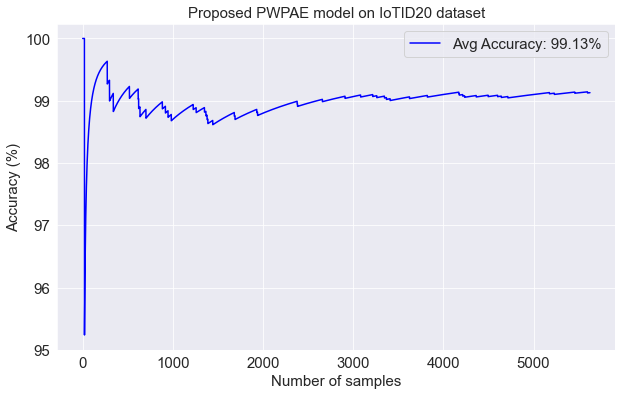

In [15]:
%%time
# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model 
name = "Proposed PWPAE model"
t, m = PWPAE(X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

### Model comparison

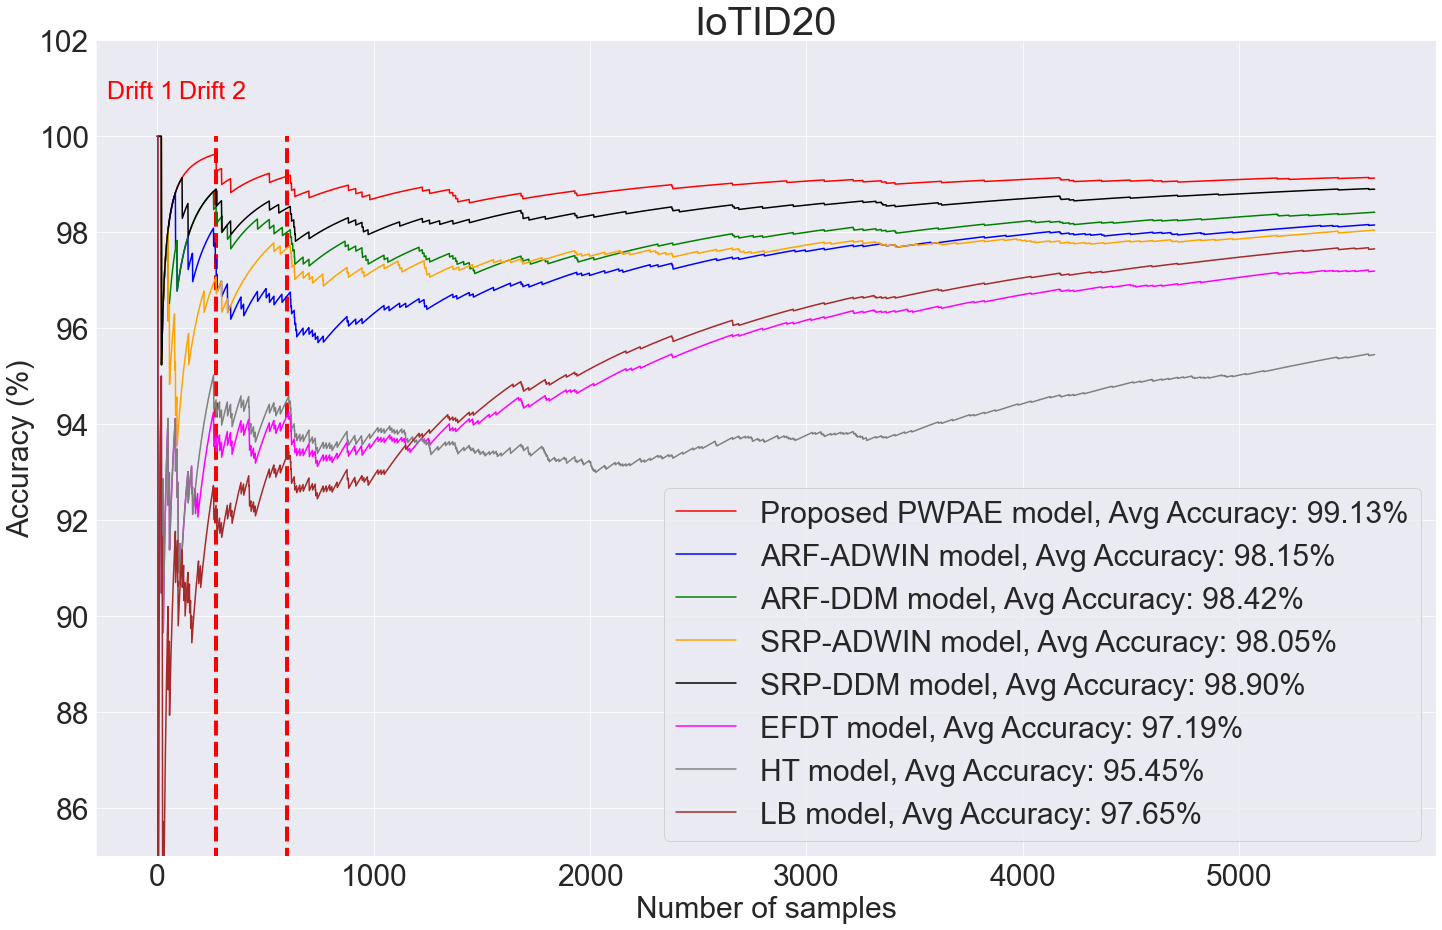

In [16]:
# Draw a comprehensive figure to compare the performance of all models
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,15)) 
sns.set_style("darkgrid")
plt.clf() 

# Plot the accuracy change of each learner
plt.plot(t,m,'-r',label=name+', Avg Accuracy: %.2f%%'%(m[-1]))
plt.plot(t,m1,'-b',label=name1+', Avg Accuracy: %.2f%%'%(m1[-1]))
plt.plot(t,m2,'-g',label=name2+', Avg Accuracy: %.2f%%'%(m2[-1]))
plt.plot(t,m3,'orange',label=name3+', Avg Accuracy: %.2f%%'%(m3[-1]))
plt.plot(t,m4,'black',label=name4+', Avg Accuracy: %.2f%%'%(m4[-1]))
plt.plot(t,m5,'magenta',label=name5+', Avg Accuracy: %.2f%%'%(m5[-1]))
plt.plot(t,m6,'grey',label=name6+', Avg Accuracy: %.2f%%'%(m6[-1]))
plt.plot(t,m7,'brown',label=name7+', Avg Accuracy: %.2f%%'%(m7[-1]))

# Draw the drift points/time
dr = [0,270,600]
for i in range(len(dr)):
    if i!=0:
        plt.text(dr[i]-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")
        
plt.legend(loc='lower right')
plt.ylim(85, 102)
plt.title('IoTID20', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.draw()